<h3>Embedding Map Extraction</h3>

In [1]:
import tensorflow as tf

In [2]:
from PIL.Image import open
from numpy import array, float32, reshape, expand_dims, argmax
from numpy.random import rand
from watermarking import extraction

In [3]:
key = extraction.Extraction.extract_key_from_image_file("static/data/watermarked_result.tif")

In [5]:
embedding_map, fg, bg = extraction.Extraction().extract_watermark(
    array(open("static/data/watermarked_result.tif"), dtype=float32),
    key
) # size 64 x 64. Perfect

initializing
enc   0  ->  64
enc   1  ->  32
enc   2  ->  16
enc   3  ->  8
enc   4  ->  4
dec   0  ->  64
dec   1  ->  32
dec   2  ->  16
dec   3  ->  8
dec   4  ->  4
(1, 1, 64, 64)
encoder
shape:  (1, 1, 64, 64)
current stack:  0
BN
(1, 64, 64, 64)
ReLU
Max pool
current stack:  1
BN
(1, 128, 32, 32)
ReLU
Max pool
current stack:  2
BN
(1, 256, 16, 16)
ReLU
Max pool
current stack:  3
BN
(1, 512, 8, 8)
ReLU
Max pool
current stack:  4
BN
(1, 512, 4, 4)
ReLU
Max pool
decoder
shape:  (1, 512, 2, 2)
Ups taking stack:  4
(512, 2, 2)  vs  (512, 3)
current size:  (512, 4, 4)
conv
BN
(1, 512, 4, 4)
Ups taking stack:  3
(512, 4, 4)  vs  (512, 3)
current size:  (512, 8, 8)
conv
BN
(1, 256, 8, 8)
Ups taking stack:  2
(256, 8, 8)  vs  (256, 3)
current size:  (256, 16, 16)
conv
BN
(1, 128, 16, 16)
Ups taking stack:  1
(128, 16, 16)  vs  (128, 3)
current size:  (128, 32, 32)
conv
BN
(1, 64, 32, 32)
Ups taking stack:  0
(64, 32, 32)  vs  (64, 3)
current size:  (64, 64, 64)
conv
BN
(1, 1, 64, 64)
resu

In [20]:
from watermarking import embedding

In [21]:
embedding.Embedding.normalized_correlation_coef(
    embedding_map, ground_truth
)

D:\Data\Portfolio\Final Project (Program)\watermarking\embedding.py:201: RuntimeWarning: invalid value encountered in true_divide
  return sum_arr(dot(extracted, watermark) / (norm(extracted) * norm(watermark)))


nan

In [ ]:
imshow(embedding_map)

In [8]:
ground_truth = array(open("Watermark.tiff"), dtype=float32)

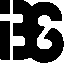

In [9]:
open("Watermark.tiff")

In [ ]:
from matplotlib.pyplot import imshow, figure, show

In [ ]:
imshow(embedding_map)

## Convolution Testing

In [ ]:
from watermarking import forward, cnn

In [ ]:
image, _ = forward.Forward(
    False,
    [[embedding_map]], # double array as batch and channel
    cnn.CNN.init_params()
).run()

In [ ]:
image.shape

# Checking Convolution

In [6]:
from watermarking import training

In [10]:
train = training.Training(
    [[bg, fg]],
    [[ground_truth]]
)
# train = training.Training(
#     [[embedding_map]],
#     [[ground_truth]]
# )

batch:  (1, 1, 2, 64, 64)
initializing
enc   0  ->  64
enc   1  ->  32
enc   2  ->  16
enc   3  ->  8
enc   4  ->  4
dec   0  ->  64
dec   1  ->  32
dec   2  ->  16
dec   3  ->  8
dec   4  ->  4


In [11]:
train.cross_entropy_per_batch([[bg, fg]], [[ground_truth]])

[0.6931473]

In [ ]:
result, cache, loss = train.run()

In [ ]:
# print(len(cache[3][0][4]))
print(cache[3][0][4][0])

In [ ]:
print(len(result[0][0]))j

In [ ]:
result = array(result)

In [ ]:
ground_truth = expand_dims(ground_truth, axis=0)

In [ ]:
ground_truth.shape

In [ ]:
j = 0
fig= figure(figsize=(8, 8))
columns = 8
rows = 8
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    imshow(result[0][j])
    j += 1
show()

<h3>(The real) Training</h3>

In [ ]:
train = training.Training(
    [embedding_map, embedding_map],
    [ground_truth, ground_truth]
)

In [ ]:
softmax, loss = train.run()

In [ ]:
print(softmax[3])

<h4>Check NC of forward only</h4>

In [ ]:
from copy import deepcopy
from watermarking import embedding

In [ ]:
print(embedding.Embedding.normalized_correlation_coef(softmax[0], ground_truth))

<h4>Try to classify softmax better</h4>

In [ ]:
classified = []
for row in softmax[0]:
    new_row = []
    for pixel in row:
        if pixel > 1:
            pixel = 1
        elif pixel < 0:
            pixel = 0
        else:
            pixel = round(pixel)
        new_row.append(pixel)
    classified.append(new_row)

In [ ]:
print(embedding.Embedding.normalized_correlation_coef(classified, ground_truth))

<h4>Try displaying the classified result</h4>

In [ ]:
from PIL.Image import fromarray
from numpy import uint8

In [ ]:
tes = fromarray(array(classified, dtype=uint8) * 255)

<p>...Okay. At least not all of them is black/white :)</p>

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(7, 7), padding='same', input_shape=(1, 64, 64), activation='relu'),
    tf.keras.layers.Conv2D(64, kernel_size=(7, 7), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(epsilon=0.001),
    tf.keras.layers.Conv2D(1, kernel_size=(7, 7), padding='same'),
    tf.keras.layers.Conv2D(1, kernel_size=(7, 7), padding='same'),
    tf.keras.layers.BatchNormalization(epsilon=0.001),
    tf.keras.layers.Activation('softmax')
])

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(1, kernel_size=(3, 3), padding='same', input_shape=(64, 64, 64)),
    tf.keras.layers.Conv2D(1, kernel_size=(3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(epsilon=0.001),
    tf.keras.layers.Conv2D(1, kernel_size=(3, 3), padding='same', activation='softmax')
])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=0.01))

In [ ]:
model.fit(
    x=result,
    y=ground_truth,
    epochs=1,
    verbose=1
)

In [ ]:
output = model.predict_proba(expand_dims(rand(64, 64, 64), axis=0))

In [ ]:
output = output.reshape((64, 64))

In [ ]:
imshow(output)

In [ ]:
normalized = []
for row in result[0][0]:
    new_row = []
    for px in row:
        if px < 0 or px > 1 - px:
            new_row.append(0)
        else:
            new_row.append(1)
    normalized.append(new_row)

In [ ]:
imshow(array(normalized))